# Fake News Classifier Final Report

Names:

Date: Tuesday, May 14, 2024

# Introduction

- What is our project?

The increase in misinformation has increased drastically in the past couple of years according to

- What is the relevance?

Being able to determine whether or not a document is fake news can be a step towards the harm reduction of misinformation.

In this project we present, an exploration of Natrual Language Processing techniques to build an accurate and robust classification algorithm that can determine whether or not a piece of text is fake news or not.

- What is the data?

The data used to train our model was collected from Kaggle (INSERT LINK) and contains over 44,000 instances of content from articles labeled "Fake" or "True". Content labeled "True" was collected from Reuters.com, a well established news source with a low bias score (INSERT LINK). While content labeled "Fake" was collected from various sites that were deemed by PolitiFact as unreliable news.

- What are our methods?

Methods for analyzing and processing the data, as well as selecting the best classifier will include:

- Exploratory data analysis and visualization
- Text cleaning and preprocessing using NLP libraries (tokenizing, lemmatizing, POS tagging, entity recognition, topic modeling)
- Building a variety of classifiers
- Evaluation our models via a variety of metrics
- Using model explainability techniques to understand our model's decisions

# Importing Necessary Libraries

In [161]:
!pip install sentencepiece


In [4]:
# libraries for loading, preprocessing, visualization
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

# libraries for NLTK
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import treebank
from nltk.stem import PorterStemmer

# libraries for spaCy
import spacy
from spacy import displacy


# libraries for Gensim
import gensim
from gensim.corpora import Dictionary

# libraries for ML models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report

# libraries for SHAP + LIME
import shap
shap.initjs()
import lime
from lime.lime_text import LimeTextExplainer


Here we are loading in spaCy's language processing model. This will be used later on to process our text into features that we can analyze and use as input for our classifier.

In [5]:
# load in spacy model
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_trf')

In [6]:
# import dataset
file_path = input("Enter the path of the csv file:")
df = pd.read_csv(file_path)

In [ ]:
df.head(10)

,title,text,subject,date,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",True
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",True
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",True
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",True
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",True


# Exploratory Data Analysis

- look at missing values
- look at size
- look at data type
- look at distribution of type
- add Mahbuba's visualizations

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   type     44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


<Axes: >

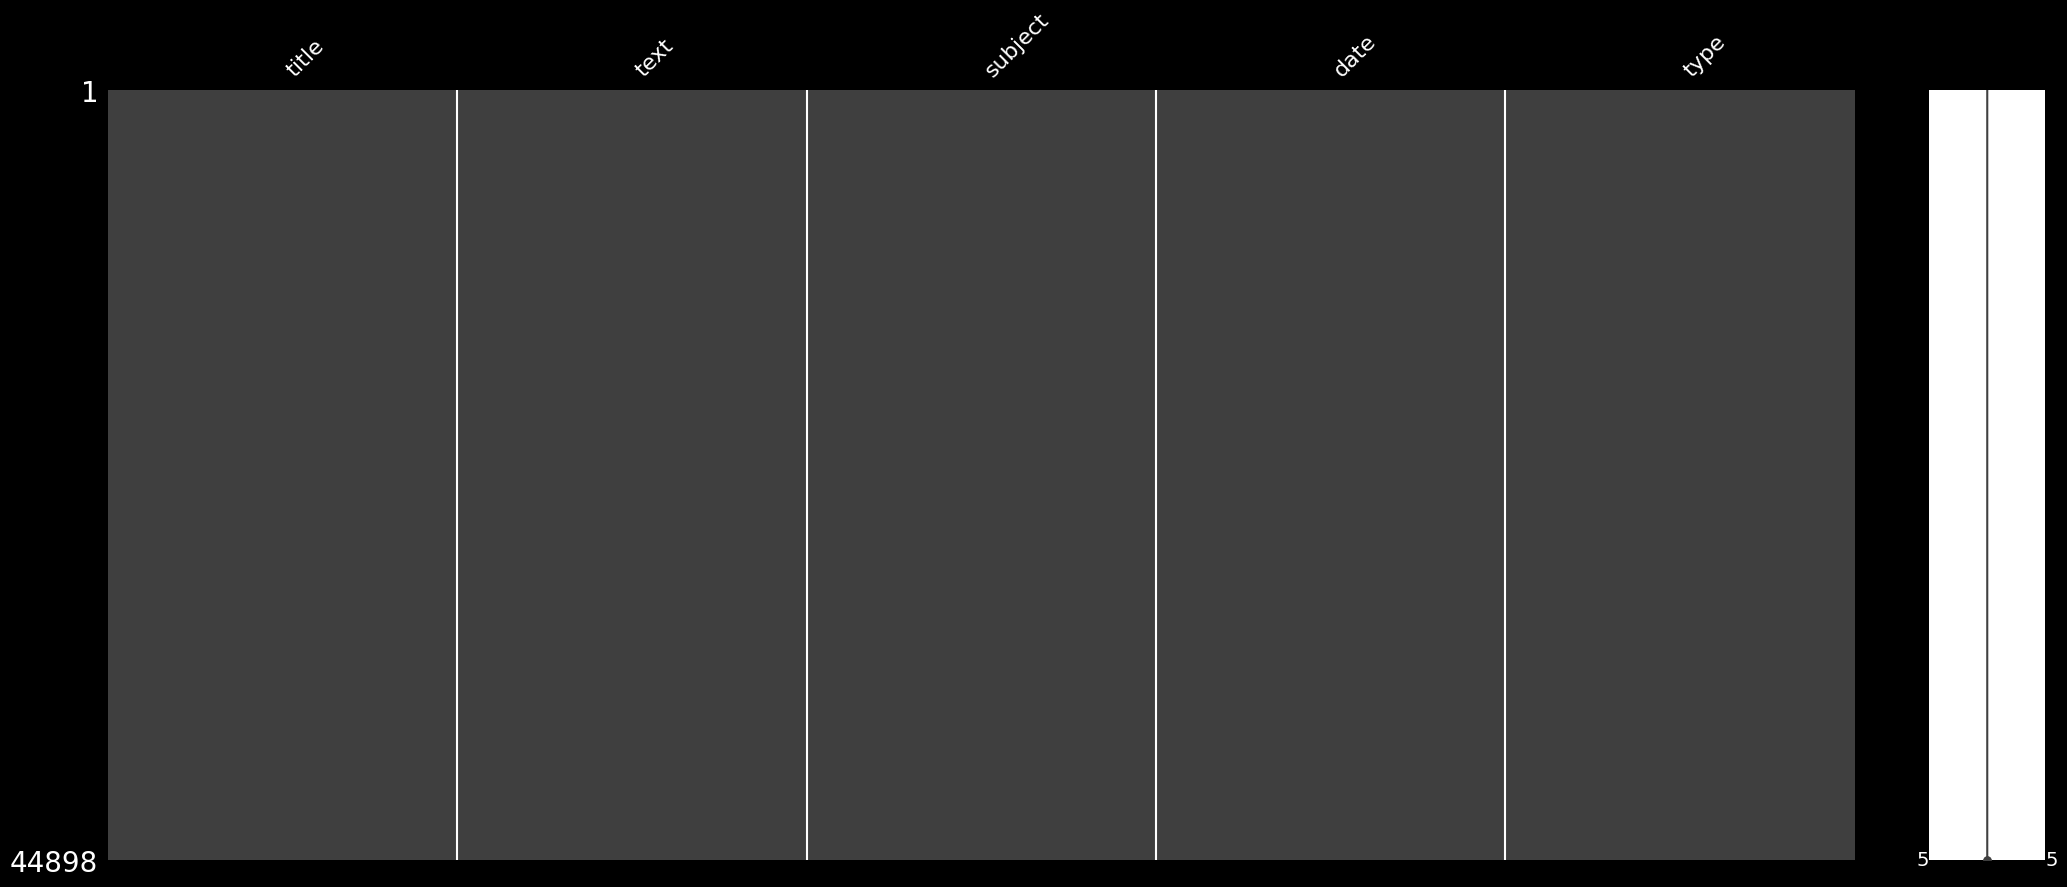

In [ ]:
msno.matrix(df)

- WHAT DID WE LEARN FROM EDA?

There are about 44,000 rows, and five columns "title", "text", "subject", "date", "target". The two most relevant features for our task will be "text", our explanatory variable, and "target", our response variable.

Additionally, we can see that the two classes, "Fake" and "True" are present in the same quantities, indicating that there is no need to take into account class imbalance.



# Text Cleaning and Preprocessing

- drop na
- lower case
- remove stop words
- may need to create a smaller dataset

In [ ]:
# Tokenize and removing stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # remove non-alphabetical characters and stopwords
    cleaned_tokens = [re.sub(r'[^a-zA-Z ]', '', text).lower() for text in tokens if text.lower() not in stop_words]
    cleaned_tokens = [token for token in cleaned_tokens if ((token not in  set(string.punctuation)))]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in cleaned_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    #stem the tokens
    porter = PorterStemmer()
    cleaned_text = " ".join(porter.stem(token) for token in processed_text.split())
    return cleaned_text

# Apply the function across the DataFrame
df['cleaned_text'] = df['text'].apply(clean_text)


In [ ]:
### CREATING A SMALLER DATASET TO TEST STUFF ###
# Separate the DataFrame into two subsets based on categories
true_df = df[df['type'] == 'True']
fake_df = df[df['type'] == 'Fake']

# Randomly sample an equal number of rows from each subset
sampled_true = true_df.sample(n=40, replace=False, random_state=42)
sampled_fake = fake_df.sample(n=40, replace=False, random_state=42)

# Combine the sampled rows into a single DataFrame
sampled_df = pd.concat([sampled_true, sampled_fake])

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

NameError: name 'df' is not defined

Stop word removal is a necessary step in preparing data from natural language processing, as it removes words that are frequently repeated and provide no value to the model for the classification task.

In [ ]:
# remove stopwords (WARNING ~30min)
def remove_stopwords(doc):
    return ' '.join([token.text for token in nlp(doc) if not token.is_stop])

sampled_df['text'] = sampled_df['text'].apply(remove_stopwords)

It is good practice to make all words in our text lowercase in order to create simplicity and prevent the model from treating the same word different because of a difference in cases.

In [ ]:
# make all words lowercase
sampled_df['text'] = sampled_df['text'].str.lower()
sampled_df.head()

,title,text,subject,date,type,cleaned_text
0,Europe rights watchdog says Turkey's emergency...,brussels (reuters) - a leading european rights...,worldnews,"October 6, 2017",True,brussel reuter lead european right watchdog ca...
1,Exclusive: Trump targets illegal immigrants wh...,"(reuters) - in september 2014, gilberto velasq...",politicsNews,"June 9, 2017",True,reuter septemb gilberto velasquez yearold hous...
2,"At G20 summit, Trump pledges $639 million in a...",hamburg (reuters) - u.s. president donald trum...,politicsNews,"July 8, 2017",True,hamburg reuter u presid donald trump saturday ...
3,Ex-Christie associates lose bid for new trial ...,new york (reuters) - a federal judge rejected ...,politicsNews,"March 2, 2017",True,new york reuter feder judg reject request new ...
4,Young blacks more open to Bernie Sanders' Whit...,"orangeburg, s.c. (reuters) - if democratic hop...",politicsNews,"February 12, 2016",True,orangeburg sc reuter democrat hope berni sande...


In [ ]:
sampled_df['cleaned_text'] = sampled_df['text'].str.replace('reuters', '')

# Natural Language Processing

- Why do we do nlp? what are the benefits? why do we need it to build out fake news classifier?

## NLTK

- mention that it is our baseline

NLTK (Natural Language Tool Kit) is the most popular natural language processing library currently available. As so, we will use it as our baseline for preprocessing text.

- pros and cons?

One of the most valueable features that this package offers is ...

However, it lacks ...


- what it does, how it works, what are some of its features?

This library tokenizes words by ...

### Tokenize

### Lemmatize

## spaCy

tokenize, lemmatize, POS tagging, entity recognition

### spaCy Tokenizing

In [ ]:
df['spacy_tokens'] = df['text'].apply(lambda x: [token.text for token in nlp(x)])

In [ ]:
df.head()

### spaCy Lemmatizing

In [ ]:
# lemmatize the text (takes much longer to run than nltk)

df['lemms'] = df['text'].apply(lambda text: [token.lemma_ for token in nlp(text)])

In [ ]:
sampled_df.head()

### spaCy Part of Speech Tagging

Part of Speech (POS) Tagging is a tool offered by spaCy that allows the user to ...

In this project, we will be using POS tagging to label each word in each article with a part of speech. We will then visualize the top five most common words for each part of speech tag in each class. 

First we will create a dictionary that holds a word and a part of speech tag.

In [ ]:
# do pos tagging and convert it into a dictionary
sampled_df['pos_tag_dict'] = sampled_df['text'].apply(lambda text: {token.text: token.pos_ for token in nlp(text)})

Next, we will get the top 5 most common words for each part of speech to use in visualization.

In [ ]:
# create a FAKE df for visualization
# select fake text
fake_pos = sampled_df[sampled_df['type'] == 'Fake']['pos_tag_dict']

# Extract POS and word into separate lists
f_pos_list = []
f_word_list = []

for pos_word in fake_pos:
    for pos, word in pos_word.items():
        f_pos_list.append(pos)
        f_word_list.append(word)

# Create DataFrame from lists
fakedf = pd.DataFrame({'Word': f_pos_list, 'POS': f_word_list})

# create mask to remove unwanted parts of speech
mask = ~fakedf['POS'].isin(['X', 'SPACE', 'PUNCT', 'SYM', 'AUX', 'CCONJ', 'PART', 'PRON'])
fakefiltdf = fakedf[mask]

# Group by POS and count occurrences of each word
pos_word_counts = fakefiltdf.groupby(['POS', 'Word']).size().reset_index(name='Count')

# Get top five most common words for each POS tag
faketop = pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')

print(faketop)

      POS          Word  Count
0     ADJ     political      9
1     ADJ        little      8
2     ADJ  presidential      7
3     ADJ           big      6
4     ADJ    republican      6
5     ADP          like     14
6     ADP          amid      2
7     ADP          away      2
8     ADP        inside      2
9     ADP       2016for      1
10    ADV             t     27
11    ADV      actually      8
12    ADV       clearly      6
13    ADV           ago      5
14    ADV     currently      4
15    DET          half      1
16    DET       is.this      1
18   INTJ          f*ck      2
19   INTJ            ok      2
20   INTJ           yes      2
21   INTJ          blah      1
22   NOUN        people     21
23   NOUN         image     17
24   NOUN          time     12
25   NOUN      campaign     11
26   NOUN    government     11
27    NUM          2016      5
28    NUM          2017      5
29    NUM             3      3
30    NUM            30      3
31    NUM             8      3
32  PROP

C:\Users\esthe\AppData\Local\Temp\ipykernel_87432\4288116148.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  faketop = pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


In [ ]:
# create a TRUE df for visualization
# select true text
true_pos = sampled_df[sampled_df['type'] == 'True']['pos_tag_dict']

# Extract POS and word into separate lists
t_pos_list = []
t_word_list = []

for pos_word in true_pos:
    for pos, word in pos_word.items():
        t_pos_list.append(pos)
        t_word_list.append(word)

# Create DataFrame from lists
truedf = pd.DataFrame({'Word': t_pos_list, 'POS': t_word_list})

# create mask to remove unwanted parts of speech
mask = ~truedf['POS'].isin(['X', 'SPACE', 'PUNCT', 'SYM', 'AUX', 'CCONJ', 'PART', 'PRON'])
truefiltdf = truedf[mask]

# Group by POS and count occurrences of each word
t_pos_word_counts = truefiltdf.groupby(['POS', 'Word']).size().reset_index(name='Count')

# Get top five most common words for each POS tag
truetop = t_pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True). drop_duplicates('Word')
truetop = truetop[truetop['Word'] != 'reuters']

print(truetop)

      POS          Word  Count
0     ADJ           new     11
1     ADJ  presidential     11
2     ADJ    republican     11
3     ADJ        public      8
4     ADJ        senior      8
5     ADP          like      7
6     ADP          amid      4
7     ADP        inside      2
8     ADP          near      2
9     ADP       outside      2
10    ADV   immediately      6
11    ADV    previously      5
12    ADV             t      5
13    ADV         ahead      3
14    ADV          away      3
16   INTJ            oh      1
17   NOUN          year     18
18   NOUN    government     16
19   NOUN        people     16
20   NOUN      campaign     14
21   NOUN       country     13
22    NUM       million      8
23    NUM            10      7
24    NUM            20      6
25    NUM          2012      6
26    NUM             8      6
28  PROPN           u.s     23
29  PROPN     president     21
30  PROPN        donald     17
31  PROPN         trump     16
32  SCONJ       despite      3
33   VER

C:\Users\esthe\AppData\Local\Temp\ipykernel_87432\1995830014.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truetop = t_pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True). drop_duplicates('Word')


Now that we've created our fake and true dataframes, we can define a color palette and visualize our results using Seaborn's bar plot function.

In [ ]:
# Get Seaborn's default color palette
palette = sns.color_palette()

# Create the dictionary with default Seaborn colors
pos_colors = {
    'ADJ': palette[0],
    'ADP': palette[1],
    'ADV': palette[2],
    'INTJ': palette[3],
    'NOUN': palette[4],
    'NUM': palette[5],
    'PROPN': palette[9],
    'SCONJ': palette[8],
    'VERB': palette[6],
    'DET': 'cyan'
}

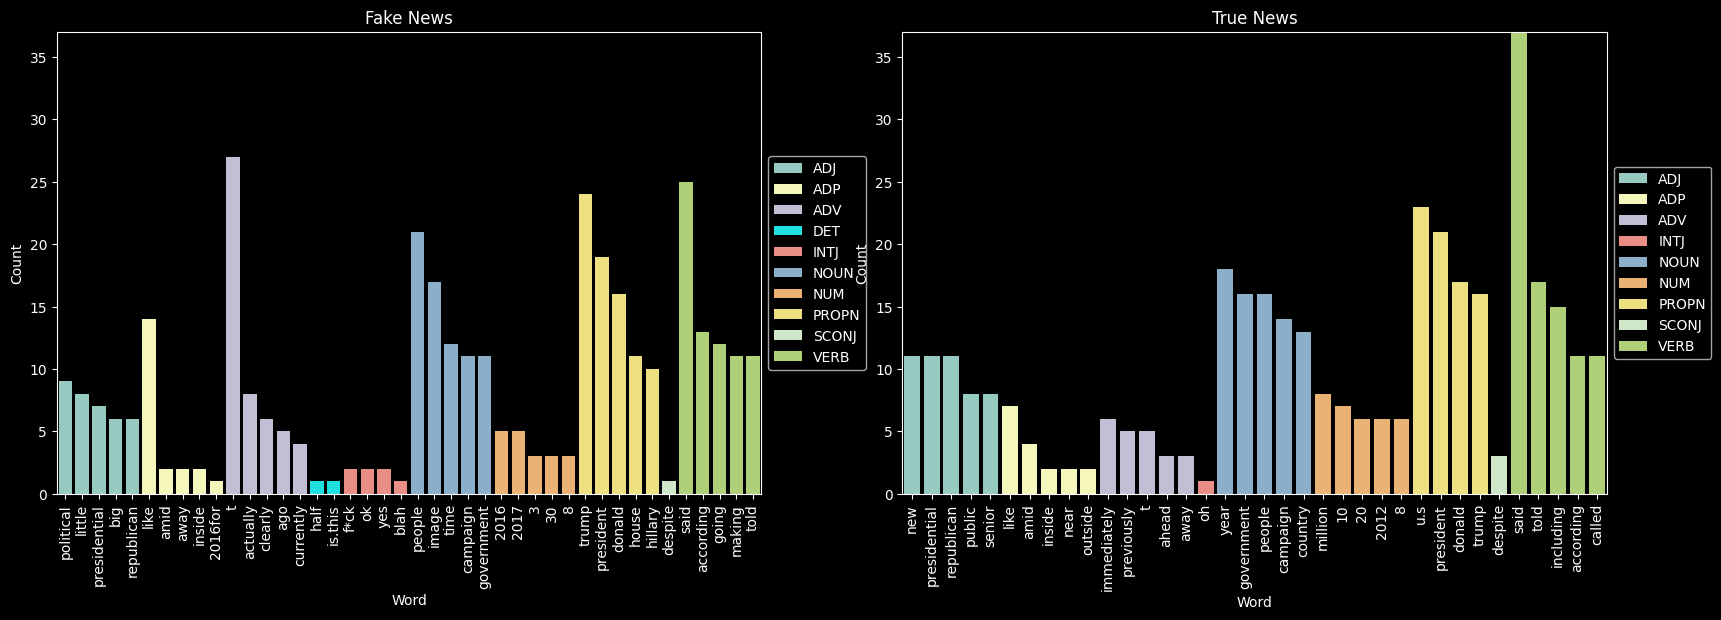

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first barplot on the first subplot
sns.barplot(data=faketop, x='Word', y='Count', hue='POS', ax=axs[0], linewidth=2, palette = pos_colors)
axs[0].set_title('Fake News')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Word')
axs[0].tick_params(axis='x', rotation=90)

# Plot the second barplot on the second subplot
sns.barplot(data=truetop, x='Word', y='Count', hue='POS', ax=axs[1], linewidth=2, palette = pos_colors)
axs[1].set_title('True News')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Word')
axs[1].tick_params(axis='x', rotation=90)

# Set y-axis limits to ensure the same scale
max_count = max(faketop['Count'].max(), truetop['Count'].max())
for ax in axs:
    ax.set_ylim(0, max_count)

# Move the legend to the left
for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

This bar plot demonstrates the differences in the top five most common words for each part of speech between "Fake" and "True" news.

One interesting observation is the presence of INTJ (interjections) such as "hi", "freaking", "f*ck", and "ok" in news articles labeled as "Fake", and the complete lack of this category in news articles labeled "True". This is likely due to the fact that unreliable news is more often written in a casual tone, or uses interjections that capture a reader's attention more easily. Given that interjections are unique to fake news, it is a possibility that a classifier could determine this to be a significant feature when learning the differences between fake and real news.

Additionally, the term "reuters" appears very frequently in articles labeled "True", and does not appear at all in articles labeled "Fake". This is likely due to the fact that all articles labeled as "True" were collected from the Reuters news site, and so have a higher frequency count of that word. Given that this characteristic is a significant difference between the two classes, it is likely that the model will recognize this as an important feature during learning. 

### spaCy Entity Recognition

spaCy's statistical entity recognition system assigns labels to contiguous spans of tokens. It works to identify a variety of named numeric entities including companies, locations, organizations, and products. In the context of our project, this is a valuable step towards allowing us to identify if there are any particular entities that are more prominent in fake news or real news.

The most common entity tags and their definitions include but are not limited to:

- GPE: Geo-Political Entity. It refers to countries, cities, states, and other named places.
- DATE: Refers to specific dates or periods mentioned in the text.
- PERSON: Individual people, including fictional and real names.
- NORP: Nationalities or religious or political groups.
- FAC: Buildings, airports, highways, bridges, etc.
- ORG: Companies, agencies, institutions, etc.
- GPE: Countries, cities, states.
- LOC: Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT: Objects, vehicles, foods, etc. (Not services.)
- EVENT: Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW: Named documents made into laws.
- LANGUAGE: Any named language.

The goal in using this tool is to visualize the top five most common words for each entity for each class and determine the differences between the two.

First we will begin the process by creating tokens of every word in each of the news articles.

In [ ]:
sampled_df['Entities_Dict'] = sampled_df['text'].apply(lambda text: {token.text: token.ent_type_ for token in nlp(text)})
sampled_df['Entities_Dict'].head()

0    {'brussels': 'GPE', '(': '', 'reuters': 'ORG',...
1    {'(': '', 'reuters': 'ORG', ')': '', '-': '', ...
2    {'hamburg': 'GPE', '(': '', 'reuters': 'ORG', ...
3    {'new': 'GPE', 'york': 'GPE', '(': '', 'reuter...
4    {'orangeburg': '', ',': '', 's.c': 'GPE', '.':...
Name: Entities_Dict, dtype: object

We will also remove all blank tokens from the dictionary.

In [ ]:
# Remove blank values in the dictionaries
for index, entity_dict in enumerate(sampled_df['Entities_Dict']):
    # Remove key-value pairs where the value is an empty string
    cleaned_entity_dict = {k: v for k, v in entity_dict.items() if v != ''}
    # Update the 'Entities_Dict' column with the cleaned dictionary
    sampled_df.at[index, 'Entities_Dict'] = cleaned_entity_dict

# Print the updated 'Entities_Dict' column
print(sampled_df['Entities_Dict'].head())

0    {'brussels': 'GPE', 'reuters': 'ORG', 'europea...
1    {'reuters': 'ORG', 'september': 'DATE', '2014'...
2    {'hamburg': 'GPE', 'reuters': 'ORG', 'u.s': 'G...
3    {'new': 'GPE', 'york': 'GPE', 'reuters': 'ORG'...
4    {'s.c': 'GPE', 'reuters': 'ORG', '-': 'DATE', ...
Name: Entities_Dict, dtype: object


Then remove all values that spaCy's model could not assign an entity to.

In [ ]:
# remove keys with no assigned entity values
def rmv_empty_ents(df):
    for _, row in df.iterrows():
        entities_copy = row['Entities_Dict'].copy()  # Create a copy of the dictionary
        for k, v in entities_copy.items():  # Iterate over the copy
            if v == '':
                del row['Entities_Dict'][k]  # Modify the original dictionary
    return df

sampled_df = rmv_empty_ents(sampled_df)
sampled_df['Entities_Dict'].head()

0    {'brussels': 'GPE', 'reuters': 'ORG', 'europea...
1    {'reuters': 'ORG', 'september': 'DATE', '2014'...
2    {'hamburg': 'GPE', 'reuters': 'ORG', 'u.s': 'G...
3    {'new': 'GPE', 'york': 'GPE', 'reuters': 'ORG'...
4    {'s.c': 'GPE', 'reuters': 'ORG', '-': 'DATE', ...
Name: Entities_Dict, dtype: object

Now that we have created a clean dictionary of words and their corresponding entity tags, we can create fake and true entity data frames that will be used for plotting.

In [ ]:
# create a TRUE df for visualization
# select true text
true_ent = sampled_df[sampled_df['type'] == 'True']['Entities_Dict']

# Extract POS and word into separate lists
t_ent_list = []
t_word_list = []

for ent_word in true_ent:
    for word, ent in ent_word.items():  # Change 'pos' to 'ent'
        t_ent_list.append(ent)  # Change 'pos_list' to 'ent_list'
        t_word_list.append(word)

# Create DataFrame from lists
truedf = pd.DataFrame({'Ent': t_ent_list, 'Word': t_word_list})  # Swap 'Ent' and 'Word'

# create mask to remove unwanted parts of speech
mask = ~truedf['Ent'].isin(['CARDINAL', 'ORDINAL', 'PERCENT', 'WORK_OF_ART','MONEY', 'DATE', 'QUANTITY', 'LANGUAGE'])
truefiltdf = truedf[mask]

# Group by POS and count occurrences of each word
t_ent_word_counts = truefiltdf.groupby(['Ent', 'Word']).size().reset_index(name='Count')  # Change 'POS' to 'Ent'

# Get top five most common words for each POS tag
ent_truetop = t_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')
ent_truetop = ent_truetop[ent_truetop['Word'] != 'reuters']

print(ent_truetop)

        Ent         Word  Count
0     EVENT    christmas      1
1     EVENT          g20      1
2     EVENT    holocaust      1
3     EVENT     memorial      1
4     EVENT     orthodox      1
5       FAC    additions      1
6       FAC      airport      1
7       FAC        beach      1
8       FAC       border      1
9       FAC    boulevard      1
10      GPE          u.s     21
11      GPE          new      8
12      GPE       states      7
13      GPE       united      7
14      GPE   washington      7
15      LAW            -      1
16      LAW          act      1
17      LAW     cleaning      1
18      LAW         code      1
19      LAW      collins      1
20      LOC       europe      3
21      LOC        river      2
22      LOC     southern      2
23      LOC         bank      1
25     NORP     american      9
26     NORP   republican      9
27     NORP   democratic      7
28     NORP  republicans      6
29     NORP    democrats      5
31      ORG        house     12
32      

C:\Users\esthe\AppData\Local\Temp\ipykernel_87432\840465264.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_truetop = t_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


In [ ]:
# create a fake df for visualization
# select fake text
fake_ent = sampled_df[sampled_df['type'] == 'Fake']['Entities_Dict']

# Extract POS and word into separate lists
f_ent_list = []
f_word_list = []

for ent_word in fake_ent:
    for word, ent in ent_word.items():  # Change 'pos' to 'ent'
        f_ent_list.append(ent)  # Change 'f_pos_list' to 'f_ent_list'
        f_word_list.append(word)

# Create DataFrame from lists
fakedf = pd.DataFrame({'Ent': f_ent_list, 'Word': f_word_list})

# create mask to remove unwanted parts of speech
mask = ~fakedf['Ent'].isin(['CARDINAL', 'ORDINAL', 'PERCENT', 'WORK_OF_ART', 'MONEY', 'DATE', 'QUANTITY', 'LANGUAGE'])
fakefiltdf = fakedf[mask]

# Group by POS and count occurrences of each word
f_ent_word_counts = fakefiltdf.groupby(['Ent', 'Word']).size().reset_index(name='Count')  # Change 'f_pos_word_counts' to 'f_ent_word_counts'

# Get top five most common words for each POS tag
ent_faketop = f_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')

print(ent_faketop)

        Ent         Word  Count
0     EVENT         city      1
1     EVENT      codecon      1
2     EVENT      hanging      1
3     EVENT           ii      1
4     EVENT          war      1
5       GPE       states      7
6       GPE       united      7
7       GPE          u.s      6
8       GPE      america      5
9       GPE          new      5
10      LAW          act      2
11      LAW    obamacare      2
12      LAW            -      1
13      LAW   affordable      1
14      LAW    agreement      1
15      LOC       europe      1
16     NORP   republican      7
17     NORP     american      6
18     NORP     democrat      5
19     NORP   democratic      5
20     NORP  republicans      5
21      ORG        house     10
22      ORG        white      6
23      ORG     congress      5
24      ORG          gop      5
25      ORG         news      5
26   PERSON        trump     23
27   PERSON       donald     16
28   PERSON      hillary     10
29   PERSON      clinton      9
30   PER

C:\Users\esthe\AppData\Local\Temp\ipykernel_87432\2192775740.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_faketop = f_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


Now we can visualize the results with Seaborn's bar plot function.

In [ ]:
# Get Seaborn's default color palette
palette = sns.color_palette()

# Create the dictionary with default Seaborn colors
ent_colors = {
    'PERSON': palette[0],
    'EVENT': palette[1],
    'FAC': palette[2],
    'GPE': palette[3],
    'LAW': palette[4],
    'LOC': palette[5],
    'NORP': palette[6],
    'ORG': palette[9],
    'PRODUCT': palette[8],
    'TIME': palette[7]
}



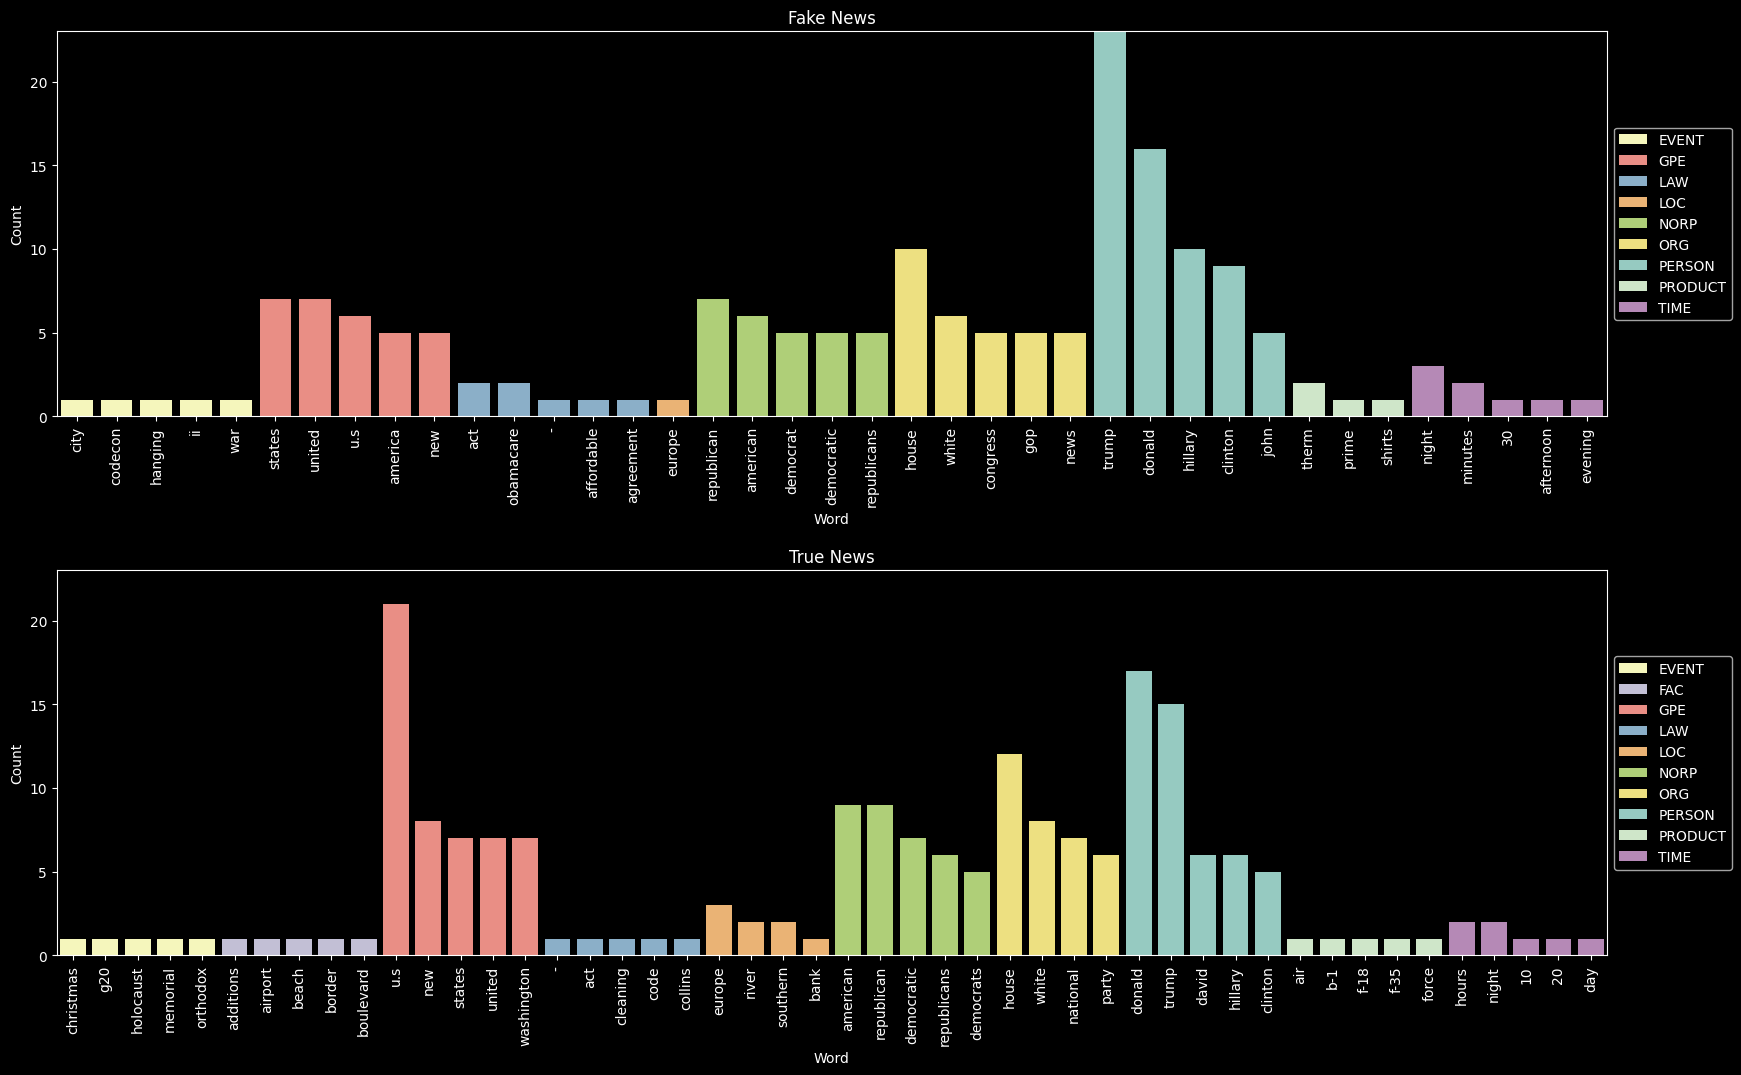

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 12))  # Change 1 to 2 for two subplots vertically

# Plot the first barplot on the first subplot
sns.barplot(data=ent_faketop, x='Word', y='Count', hue='Ent', ax=axs[0], linewidth=8, palette=ent_colors)
axs[0].set_title('Fake News')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Word')
axs[0].tick_params(axis='x', rotation=90)

# Plot the second barplot on the second subplot
sns.barplot(data=ent_truetop, x='Word', y='Count', hue='Ent', ax=axs[1], linewidth=8, palette=ent_colors)
axs[1].set_title('True News')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Word')
axs[1].tick_params(axis='x', rotation=90)

# Set y-axis labels to integers
for ax in axs:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

# Set y-axis limits to ensure the same scale
max_count = max(ent_faketop['Count'].max(), ent_truetop['Count'].max())
for ax in axs:
    ax.set_ylim(0, max_count)

# Move the legend to the left
for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust space between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()


These figures show a significant difference between the two classes...

## Gensim

Gensim is another poular natural language proessing library that offers the unique ability to ...

### Word2Vec

Word2Vec is ...

In [ ]:
# building the word2vec model
model = gensim.models.Word2Vec(
    window = 6,
    min_count = 1,
    workers = 4
)
model.build_vocab(df['cleaned_text'])

NameError: name 'gensim' is not defined

In [ ]:
# training the model
model.train(df['cleaned_text'], total_examples=model.corpus_count, epochs=5)

# saving the model
model.save("word2vec/word2vec_model")

In [ ]:
# a function for finding the average of the word vectors 
def get_average_word2vec_vector(text, model, word_dim):
  vec = np.zeros((word_dim,))  
  count = 0
  for word in text:
    if word in model.wv:  
      vec += model.wv[word]
      count += 1
  if count != 0:
    vec /= count  
  return vec

# Get word dimensions from the model
word_dim = model.vector_size

# Apply the function to each cleaned_text
word_vectors = [get_average_word2vec_vector(text, model, word_dim) for text in df['cleaned_text']]

In [ ]:
# adding the word vectors to the data
df['word_vectors'] = word_vectors

The word2vect word embedding learns the association between the words. It uses cosine metrics to measure the semantic similarity. Therefore a value closer to 1 actually means that the word is similar to closer words and vice versa. 


### Topic Modeling

Topic Modeling is useful for...

Here we will be using the Latent Dirichlet Allocation (LDA), which is the most popular technique for topic modeling.

It works by...

https://medium.com/nlplanet/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06#3363

In [ ]:
!pip install gensim


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

C:\Users\esthe\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# Split dataset into fake and real
fakedf = sampled_df[sampled_df['type'] == 'Fake'][['type', 'text']]
truedf = sampled_df[sampled_df['type'] == 'True'][['type', 'text']]
# original df
sampled_df1 = sampled_df[['type', 'text']]

# remove punctuation
chars_to_remove = r'[.,():?\-!”“*]'

# Apply the regex pattern to the 'text' column
fakedf['text'] = fakedf['text'].str.replace(chars_to_remove, '')
fakedf['text'] = fakedf['text'].str.replace(' s ', '')
fakedf['text'] = fakedf['text'].str.replace(' t ', '')

truedf['text'] = truedf['text'].str.replace(chars_to_remove, '')
truedf['text'] = truedf['text'].str.replace(' s ', '')
truedf['text'] = truedf['text'].str.replace(' t ', '')


sampled_df1['text'] = sampled_df['text'].str.replace(chars_to_remove, '')
sampled_df1['text'] = sampled_df['text'].str.replace(' s ', '')
sampled_df1['text'] = sampled_df['text'].str.replace(' t ', '')



NameError: name 'sampled_df' is not defined

In [ ]:
# Convert text column to list of documents
fake_docs = [doc.split() for doc in fakedf['text']]
true_docs = [doc.split() for doc in truedf['text']]
sampled_docs = [doc.split() for doc in sampled_df1['text']]

# Create dictionaries
fake_dict = corpora.Dictionary(fake_docs)
true_dict = corpora.Dictionary(true_docs)
sampled_dict = corpora.Dictionary(sampled_docs)

# Create corpora
fake_corp = [fake_dict.doc2bow(doc) for doc in fake_docs]
true_corp = [true_dict.doc2bow(doc) for doc in true_docs]
sampled_corp = [sampled_dict.doc2bow(doc) for doc in sampled_docs]



In [ ]:
# Train LDA models
fake_lda = LdaModel(fake_corp, num_topics=4, id2word=fake_dict)
true_lda = LdaModel(true_corp, num_topics=4, id2word=true_dict)
sampled_lda = LdaModel(sampled_corp, num_topics=2, id2word=sampled_dict)



Visualization for entire dataset, Fake and True, separated into two topics.

In [ ]:
# Visualize the topics for both classes
sampled_lda_viz = gensimvis.prepare(sampled_lda, sampled_corp, sampled_dict, n_jobs = 1)
pyLDAvis.display(sampled_lda_viz)

Visualization for Fake news, split into four different topics.

In [ ]:
# Visualize the topics for fake classes
fake_lda_viz = gensimvis.prepare(fake_lda, fake_corp, fake_dict, n_jobs = 1)
pyLDAvis.display(fake_lda_viz)



Visualization for True news split into 4 different topics.

In [ ]:
# visualize topics for true class
true_lda_viz = gensimvis.prepare(true_lda, true_corp, true_dict, n_jobs = 1)
pyLDAvis.display(true_lda_viz)

# Building Classification Models

In this section we will now use our preprocessed data to serve as an input to our classifier. We will test the accuracy of a variety of classifiers and select the one with the best performance. Next, we will use the GridSearch technique to select the optimal hyperparameters and further improve the performance of our model.

Each of the classifiers selected goes about a classification task in a different way. The classifiers we have selected for this project are:

- Decision Tree Classifier
- K-Nearest Neighbors
- XGBoost
- Logistic Regression
- 

### Decision Tree Classifier

In this section we will build and train a Decision Tree Classifier. Decision Tree Classifiers work by ...

In [ ]:
# defining X and y arrays
# X = word_vectors
X = df['cleaned_text'].values
y = df['target'].values

KeyError: 'cleaned_text'

In [ ]:
# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

In [ ]:
# defining the Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [ ]:
# defining the classification model
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train_vec,y_train)

DecisionTreeClassifier()

In [ ]:
# predicting the test values
y_pred = tree_clf.predict(X_test_vec)
# printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7649
           1       1.00      0.99      0.99      7168

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



# Evaluating Model Performance

Evaluation model performance is an essential part of this project, as it will allow us to concretely distinguish between the performances of each model and select the best one.

Evaluation metrics for our classifiers will include:

- 

- what metrics are we using to evaluate models? how do they work? how are they different? why did we pick that particular evaluation metric?

- ALSO SHOW WHAT EXACTLY WAS MISCLASSIFIED, AND PLOT IT?

- ADD PLOTS COMPARING THE PERFORMANCE OF EACH MODEL (MAHBUBA)

# Model Explainability

Model explainability is crucial when it comes to being able to safely trust a model's decisions enough to actually be used. It can help us see how a model is making decisions and can help identify potential issues in a model such as unfair bias.

In this section, we will use two different methods of model explainability:

- SHAP will be used for global interpretability, and is well suited for complex tasks to provide a list of feature contributions
- LIME on the other hand, is much better suited for localized interpretability and looking at individual predictions, especially in the context of text classification.

https://www.markovml.com/blog/lime-vs-shap#comparison-of-lime-and-shap


## Using Decision Tree classifier features

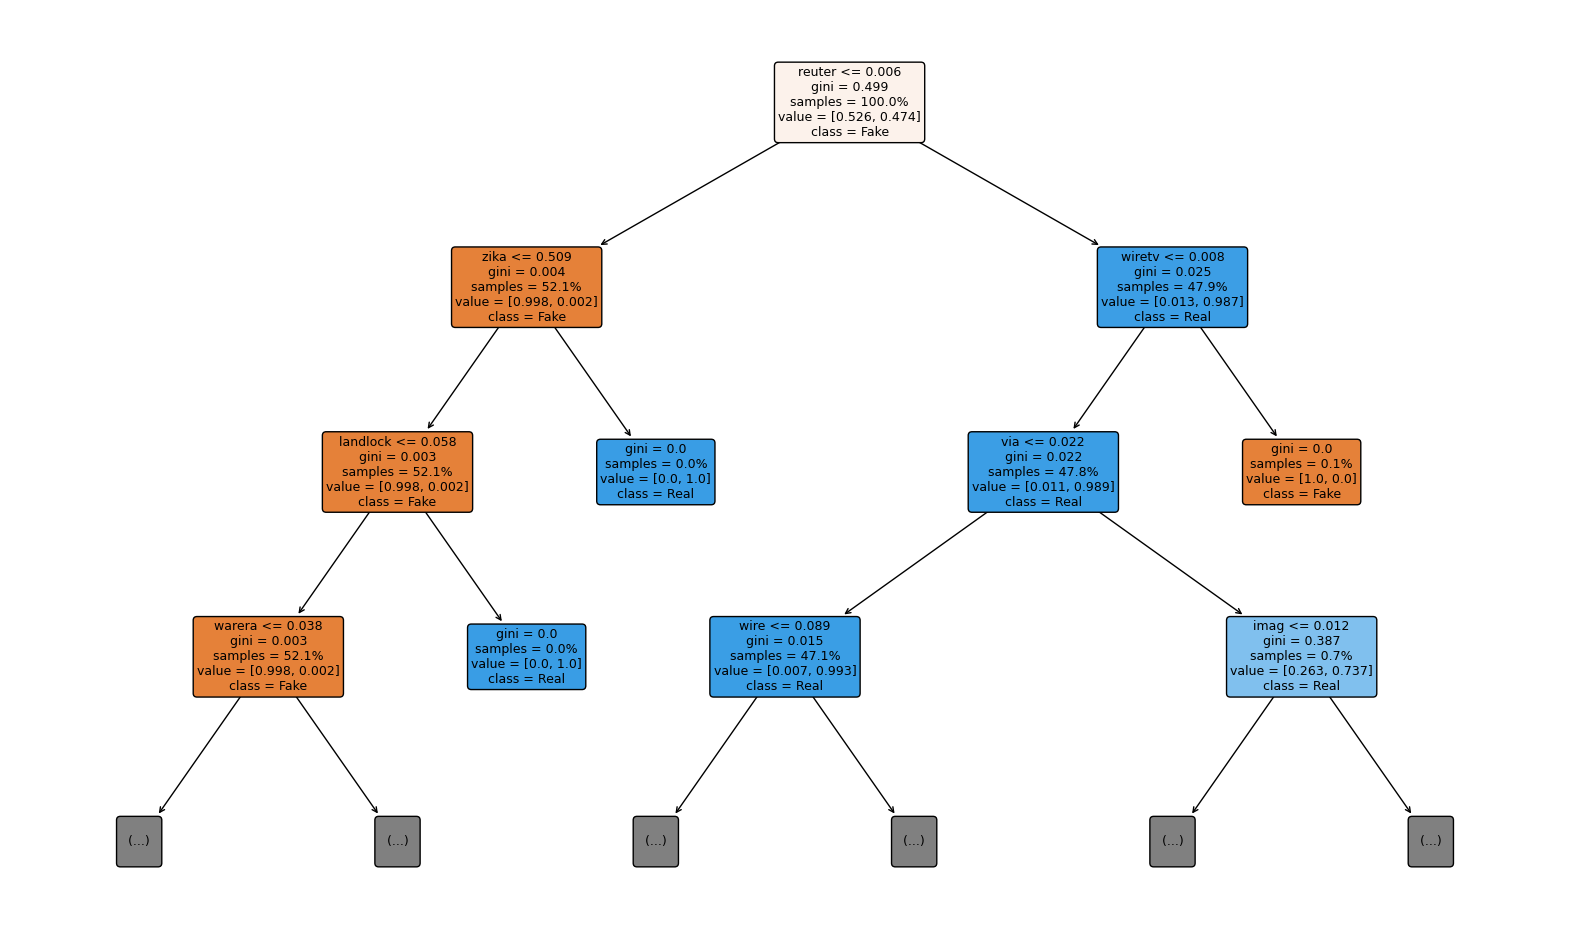

In [ ]:
class_names = ["Fake", "Real"]

fig = plt.figure(figsize=(20, 12))
vis = tree.plot_tree(
    tree_clf,
    class_names=class_names,
    feature_names = vectorizer.get_feature_names_out(),
    max_depth=3,
    fontsize=9,
    proportion=True,
    filled=True,
    rounded=True
)
plt.show()

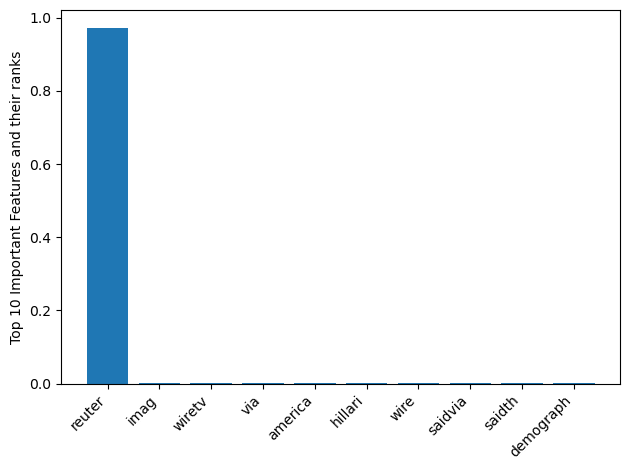

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_importance = tree_clf.feature_importances_
inds = np.argsort(np.abs(feature_importance))[::-1]
top_10_inds = inds[:10]
fig, ax = plt.subplots()
rank = np.arange(10)
ax.bar(rank, feature_importance[top_10_inds])
ax.set_xticks(rank)
ax.set_xticklabels(np.array(feature_names)[top_10_inds], rotation=45, ha='right')
ax.set_ylabel("Top 10 Important Features and their ranks")
plt.tight_layout()
plt.show()

- what is it, how does it work?

The above tree visualization of the classifier indicates that the classifier uses 'reuter' feature as one of the main feature to decide whether the text is fake or real. In the next level, 'zika' and 'wiretv' are used to split the data into the respective classes based on certain threshold values for the features. The bar chart on the feature importance also indicates that the 'reuter' feature have a huge significance in influencing the model decision compared to other features. 

## SHAP

- what is it, how does it work?

In [ ]:
# getting the feature names from tfidf vectorizer
feature_names = vectorizer.get_feature_names_out()
# getting the shap values
explainer = shap.Explainer(tree_clf, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape)

 99%|===================| 29343/29634 [00:52<00:00]        

(14817, 16341, 2)


harrisburg pa reuter u presid donald trump hit road saturday celebr first day white hous cheer support campaignstyl ralli tout initi achiev lash critic trump told pennsylvania crowd get start meet campaign promis repeatedli attack incompet dishonest medium say tell truth administr accomplish administr deliv everi singl day great citizen countri trump said harrisburg pennsylvania keep one promis anoth frankli peopl realli happi it ralli occur day climat march thousand protest surround white hous also coincid annual blackti white hous press dinner washington trump staff chose skip press dinner said unfair treatment press trump said thrill away washington swamp larg group hollywood actor washington medium consol hotel ballroom nation capit right trump said loud boo crowd medium job honest tell truth medium deserv big fat fail grade trump list said key earli accomplish includ success confirm u suprem court justic neil gorsuch clear away mani regul environ busi also list approv keyston xl d

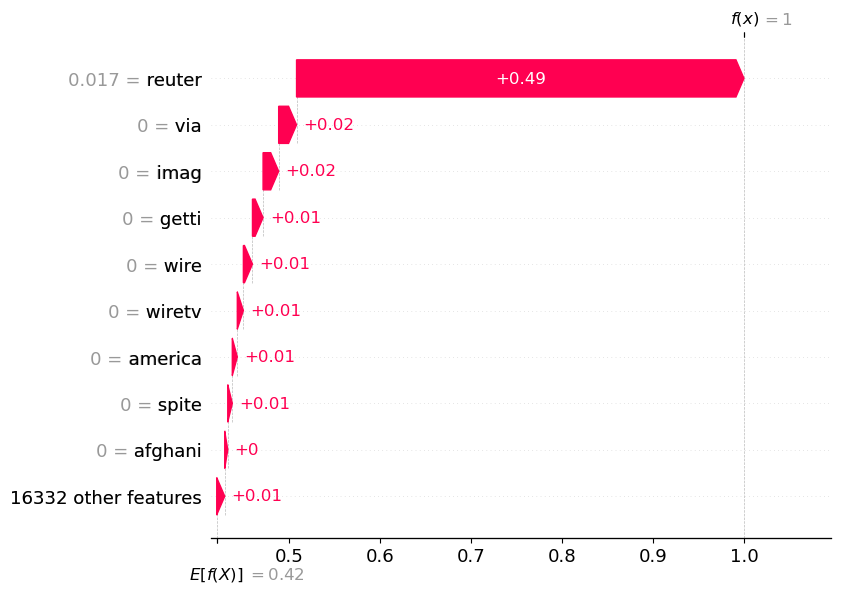

In [ ]:
# getting the shap waterfall plot for the 7th test data
shap.initjs()

ind = 6
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

madonna took instagram late thursday promot upcom antidonald trump protest march share photo woman shoe compani nike logo appar shave public hair yasssssssss nakidmagazin madonna wrote ad million woman march washington dc jan yasssssssss nakidmagazin million woman s march washington dc jan photo mariu sperlicha post share madonna madonna jan pm psta breitbart news previous report thousand woman expect travel nation capit woman march washington protest presidentelect donald trump inaugurationth organ said want event send bold messag new administr first day offic world woman right human right earlier week singer kati perri cher actress scarlett johansson zendaya debra mess juliann moor announc expect particip januari eventth yearold rebel heart singer spent month slam trump campaign drum support hillari clinton octob madonna famous offer oral sex anyon vote former democrat nomineelast month madonna admit trump elect left devast entir stori breitbart


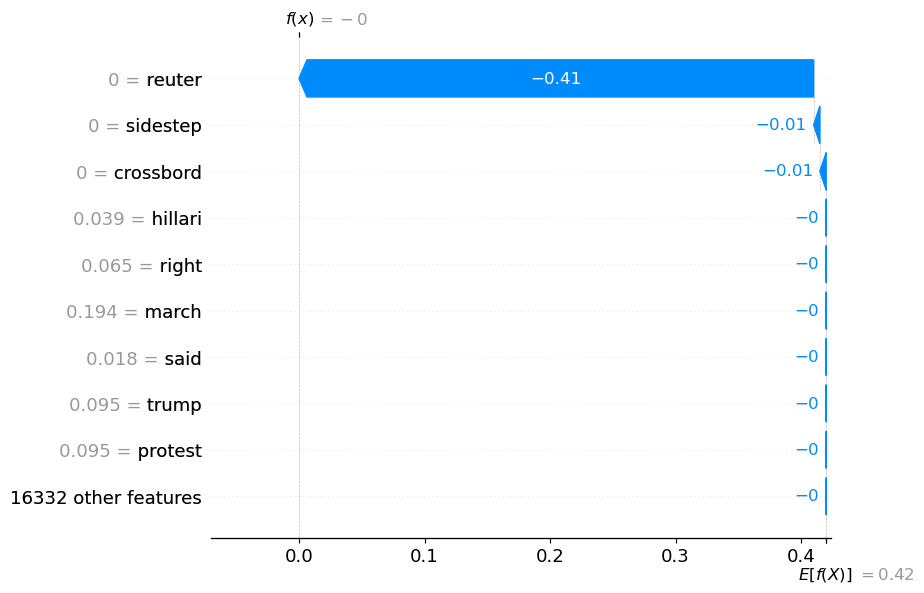

In [ ]:
# getting the shap waterfall plot for the 11th test data
shap.initjs()

ind = 10
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

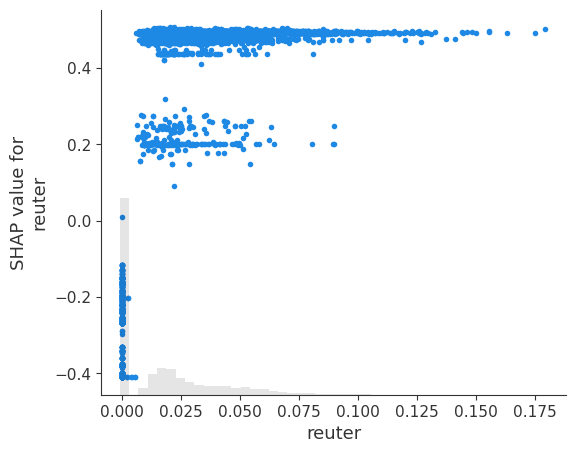

In [ ]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("reuter"),1])

The above plot shows how the 'reuter' feature influences the model in predicting an object as class 1 - real. Most of the shap values for this feature lies closer to 0.5 implying its importance for the classifier in predicting classes as real.

- What do the result show, or what do they mean?

  From the three waterfall plots above, it is clear that the model uses the word 'reuter' as the primary indicator of whether a text classifies as fake or real. If the shap value of 'reuter' is greater than 0, it classifies the text as real and vice versa.

## LIME

https://c3.ai/glossary/data-science/lime-local-interpretable-model-agnostic-explanations/

- what is it, how does it work?

Local Interpretable Model-Agnostic Explanations (LIME) is a technique for approximating a black box machine learning model with a local interpretable model to explain an individual prediction.

- run lime multiple times and on a larger sample size

First we will create tokens of every word in each article.

In [ ]:
# Define a custom tokenizer using spaCy to be used in Tf-idf
def custom_tokenizer(text):
    return [token.lemma_ for token in nlp(text)]

Next we will create a pipeline to hold the Tf-idf vectorizer and our classifier. 

# CHANGE THE CLASSIFIER TO USE OUR BEST ONE!!!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [ ]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

# Create a random forest model
forest_model = RandomForestClassifier()

# Create a pipeline combining TF-IDF vectorization and random forest model
tfidf_forest = make_pipeline(tfidf, forest_model)

Split our data into training and testing.

In [ ]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(sampled_df['text'], sampled_df['type'], random_state = 1, stratify = sampled_df['type'], test_size = 0.3)

Fit our pipeline to our data.

In [ ]:
# Train random forest model on your text data and labels
tfidf_forest.fit(X_train, y_train)

c:\Users\esthe\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x000001E7AC716EF0>)),
                ('randomforestclassifier', RandomForestClassifier())])

Create the LIME text explainer instance.

In [ ]:
# Create LimeTextExplainer instance
explainer = LimeTextExplainer(class_names=tfidf_forest.classes_)

In [ ]:
text = X_test.tolist()
print(text[0])

hillary   formidable opponent   comes women voters  hillary clinton trouble attracting high  powered women new york talk hosted silda wall spitzer weeks campaign officially kicks  sources said ticket sales fizzled intimate  $ 2700   person    women   meeting monday  event thrown open men 11th hour  deadline extended buy tickets    conversation hillary clinton   event midtown law firm akin gump originally aiming attract 125 women  email invitation seen page said event   women    friday    d sold 50 tickets  threw open men    source said    ticket sales supposed close 10 am sunday  hostesses working phones pushed deadline till monday  hear 90 attendees included bill clinton aide rep sean patrick maloney husband  randy florke  maurice tempelsman  jill braufman  wife hedge funder daniel nir   jean shafiroff susan cole  event began noon  clinton arrived 1 pm   royal blue jacket black pants    took pictures donors delivered half  hour speech leaving 2 pm silda introduced clinton   tough  aut

Fit the LIME explainer into a document of choice. VISUALIZE ONE THAT IS FAKE AND ONE THAT IS TRUE

In [ ]:
# Explain the first instance (takes a while to run)
exp_forest = explainer.explain_instance(text[10], tfidf_forest.predict_proba, num_features = 6)

In [ ]:
# Show explanation in notebook
exp_forest.show_in_notebook(text=text)

c:\Users\esthe\anaconda3\lib\site-packages\lime\explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


- What do the result show, or what do they mean?

# Conclusion

- Short overview of whole project: why? what? how?

In an era where we have access to an unthinkable amount of information at our fingertips, misinformation and fake news flourishes, disguising itself amongst truthful facts and causing the spread of incorrect and dangerous medical information, sowing distrust between people and politicians, and exacerbating social and political divides. 

Being able to tell the difference between fake and real news is crucial in a time like this, and could help mitigate the spread of dangerous or inflamatory information.

Our project attempted to build a classification model to determine whether or not a given article was unreliable and could be classified as "fake" news. We performed a variety of natural language processing techniques and selected the model with the best performance. Additionally, we provided a variety of helpful visualizations that aid in understanding our best model's decisions.

- where the data was found, what is its structure



- how the data was pre-processed and cleaned



- language processing techniques and what they showed us, how are they different?



- models, how they performed, how are they unique



- model explainability, how did the model make decisions?



- model evaluation, what does it mean in the greater context?



- conclusion